In [1]:
import os, random, time, json, cv2
import numpy as np
import pandas as pd
import albumentations as A
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from albumentations.pytorch import ToTensorV2

import torch, torchvision, torchmetrics, torchsummary
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset

## Some classes

### CNN

In [21]:
class ConvolutionalBlock(nn.Module):
    def __init__(
            self,
            in_channels: int=1,
            out_channels: int=3,
            kernel_size: int=3,
            stride: int=1,
            padding: int=1,
            padding_mode: str='zeros',
            activation=nn.ReLU(),
            pool_kernel_size: int=3,
            pool_stride: int=1,
            pool_padding: int=1
    ):
        super(ConvolutionalBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.padding_mode = padding_mode
        self.activation = activation
        self.pool_kernel_size = pool_kernel_size
        self.pool_stride = pool_stride
        self.pool_padding = pool_padding

        # Check parameters consistency
        if kernel_size % 2 == 0:
            assert kernel_size == stride, f"Conv: Stride {stride} must be equal to  even kernel size {kernel_size}."
        else:
            assert ((kernel_size-1) / 2 == padding) & stride == 1, f"Conv: Invalid padding {padding} for the given kernel size {kernel_size}"
        if pool_kernel_size % 2 == 0:
            assert pool_kernel_size == pool_stride, f"Pooling: Stride {pool_stride} must be equal to even kernel size {pool_kernel_size}."
        else:
            assert ((pool_kernel_size-1) / 2 == pool_padding) & pool_stride == 1, f"Pooling: Invalid padding {pool_padding} for the given kernel size {pool_kernel_size}"

        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, padding_mode=padding_mode),
            activation,
            nn.MaxPool2d(pool_kernel_size, pool_stride, pool_padding)
        )

    def forward(self, x):
        return self.conv_block(x)

    def getConvOutputShape(self, in_shape):
        return (self.out_channels,
                (in_shape[1] - self.kernel_size + 2*self.padding) // self.stride + 1,
                (in_shape[2] - self.kernel_size + 2*self.padding) // self.stride + 1)

    def getPoolOutputShape(self, in_shape):
        return (self.out_channels,
                (in_shape[1] - self.pool_kernel_size + 2*self.pool_padding) // self.pool_stride + 1,
                (in_shape[2] - self.pool_kernel_size + 2*self.pool_padding) // self.pool_stride + 1)

    def getOutputShape(self, in_shape):
        conv_shape = self.getConvOutputShape(in_shape)
        pool_shape = self.getPoolOutputShape(conv_shape)
        return pool_shape

In [22]:
class CNN(nn.Module):

    def __init__(
            self,
            conv_blocks: list,
            image_shape: tuple=(1, 28, 28),
            n_classes: int=10,
            out_neurons: int=64,
            activation=nn.ReLU(),
            criterion=nn.CrossEntropyLoss(),
            dropout_rate: float=0.5,
            init_type: str='xavier',
            device: str='cpu'
    ):
        super(CNN, self).__init__()
        for conv_block in conv_blocks:
            image_shape = conv_block.getOutputShape(image_shape)
        self.out_shape = image_shape
        self.in_neurons = self.out_shape[0] * self.out_shape[1] * self.out_shape[2]
        self.out_neurons = out_neurons
        self.n_classes = n_classes
        self.activation = activation
        self.criterion = criterion
        self.dropout_rate = dropout_rate
        self.init_type = init_type
        self.device = device

        # Define layers
        self.conv_blocks = nn.ModuleList(conv_blocks)
        self.fully_connected = nn.Sequential(
                nn.Linear(self.in_neurons, out_neurons),
                activation,
                nn.Dropout(dropout_rate),
                nn.Linear(out_neurons, n_classes)
        )

        # Initialize the parameters.
        self.initialize_weights(init_type)

        # Define the metrics.
        self.metrics = {
            'epochs': [], 
            'loss': {'train': [], 'val': [], 'test': None}, 
            'accuracy': {'train': [], 'val': [], 'test': None}, 
            'time': 0.0
        }

    def initialize_weights(self, init_type):
        for layer in self.fully_connected:
            if isinstance(layer, nn.Linear):
                if init_type == 'xavier':
                    nn.init.xavier_uniform_(layer.weight)
                elif init_type == 'he':
                    nn.init.kaiming_uniform_(layer.weight, nonlinearity='relu')
                else:
                    nn.init.normal_(layer.weight, mean=0, std=0.01)
                if layer.bias is not None:
                    nn.init.uniform_(layer.bias, a=0, b=1)

    def forward(self, x):
        for block in self.conv_blocks:
            x = block(x)
        x = x.view(-1, self.in_neurons)
        return self.fully_connected(x)
    
    def trainBatch(self, inputs_batch, targets_batch, optimizer):
        if self.device != 'cpu':
            inputs_batch = inputs_batch.to(self.device, non_blocking=True)
            targets_batch = targets_batch.to(self.device, non_blocking=True)
        predictions_batch = self.forward(inputs_batch)          # forward pass
        loss = self.criterion(predictions_batch, targets_batch) # compute the training loss
        optimizer.zero_grad()                                   # zero the gradients
        loss.backward()                                         # backward pass
        optimizer.step()                                        # update the parameters (weights and biases)
        return loss.item()

    def predict(self, inputs):
        if self.device != 'cpu':
            inputs = inputs.to(self.device)
        self.eval()
        with torch.no_grad():
            predictions = self.forward(inputs)
        _, predictions = torch.max(predictions.cpu().data, 1)
        return predictions

    def computeLoss(self, dataloader):
        loss = 0.0
        samples = 0
        self.eval() # set the model to evaluation mode
        with torch.no_grad():   
            for inputs_batch, targets_batch in dataloader:
                if self.device != 'cpu':
                    inputs_batch = inputs_batch.to(self.device, non_blocking=True)
                    targets_batch = targets_batch.to(self.device, non_blocking=True)
                predictions_batch = self.forward(inputs_batch)                          # forward pass
                batch_loss = self.criterion(predictions_batch, targets_batch).item()    # compute the loss
                loss += batch_loss * inputs_batch.size(0)                               # accumulate the weighted loss
                samples += inputs_batch.size(0)                                         # accumulate the number of samples
        return loss / samples
    
    def computeAccuracy(self, dataloader):
        correct, total = 0, 0
        self.eval() # set the model to evaluation mode
        with torch.no_grad():
            for inputs_batch, targets_batch in dataloader:
                if self.device != 'cpu':
                    inputs_batch = inputs_batch.to(self.device)
                    targets_batch = targets_batch.to(self.device)
                predictions_batch = self.forward(inputs_batch)      # forward pass
                correct += (predictions_batch.argmax(dim=1) == targets_batch).sum().item()
                total += inputs_batch.size(0)
        return correct / total
    
    def fit(self, train_dataloader, optimizer=optim.Adam, epochs=30, lr=1e-4, 
        regularization=0.0, eval_dataloader=None, verbose=True, epch_print=1, 
        tolerance=1e-3, patience=5):

        # Set the starting epoch
        last_epoch = self.metrics['epochs'][-1] if self.metrics['epochs'] else 0
        starting_epoch = last_epoch + 1
    
        # Set the optimizer
        optimizer = optimizer(self.parameters(), lr=lr, weight_decay=regularization)

        # Variables for early stopping
        error_loss, error_accuracy = 1, 1
        old_loss, old_accuracy = None, None
        epochs_since_improvement = 0

        # Start the training
        start_time = time.time()
        for i in range(epochs):
            self.train()
            for train_batch in train_dataloader:
                self.trainBatch(train_batch[0], train_batch[1], optimizer)
                if self.device == "gpu":
                    torch.cuda.empty_cache()
                elif self.device == "mps":
                    torch.mps.empty_cache()
                else:
                    pass

            # Evaluate the model
            self.eval()
            train_loss = self.computeLoss(train_dataloader)
            train_acc = self.computeAccuracy(train_dataloader)
            self.metrics['epochs'].append(starting_epoch + i)
            self.metrics['loss']['train'].append(train_loss)
            self.metrics['accuracy']['train'].append(train_acc)
            if eval_dataloader:
                eval_loss = self.computeLoss(eval_dataloader)
                eval_acc = self.computeAccuracy(eval_dataloader)
                self.metrics['loss']['val'].append(eval_loss)
                self.metrics['accuracy']['val'].append(eval_acc)

                # Check early stopping conditions on eval set
                if i == 0:
                    old_loss, old_accuracy = eval_loss, eval_acc
                else:
                    error_loss = abs(eval_loss - old_loss) / old_loss
                    error_accuracy = abs(eval_acc - old_accuracy) / old_accuracy
                    old_loss, old_accuracy = eval_loss, eval_acc
            else:
                # Check early stopping conditions on train set
                if i == 0:
                    old_loss, old_accuracy = train_loss, train_acc
                else:
                    error_loss = abs(train_loss - old_loss) / old_loss
                    error_accuracy = abs(train_acc - old_accuracy) / old_accuracy
                    old_loss, old_accuracy = train_loss, train_acc
            
            if (error_loss <= tolerance) and (error_accuracy <= tolerance):
                epochs_since_improvement += 1
            else:
                epochs_since_improvement = 0
            
            # Print the progress
            if verbose and (i + 1) % epch_print == 0:
                eval_loss = eval_loss if eval_dataloader else 'N/A'
                text = f"Epoch {starting_epoch + i}/{starting_epoch + epochs}: "
                text += f"Loss ({train_loss:.4g}, {eval_loss:.4g}) \t "
                text += f"Accuracy ({100*train_acc:.2f}%, {100*eval_acc:.2f}%)"
                print(text)

            # Early stopping check
            if epochs_since_improvement >= patience:
                print(f"Early stopping triggered after {i + 1} epochs.")
                break

        self.metrics['time'] += time.time() - start_time

    def size(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

    def save(self, model_path: str="cnn.pth", metrics_path: str="metrics.txt"):
        torch.save(self.state_dict(), model_path)
        with open(metrics_path, 'w') as f:
            f.truncate()
            json.dump(self.metrics, f)
        f.close()

    def load(self, model_path: str="cnn.pth", metrics_path: str="metrics.txt"):
        self.load_state_dict(torch.load(model_path))
        with open(metrics_path, 'r') as f:
            self.metrics = json.load(f)
        f.close()
        self.to(self.device)

    def plotMetrics(self, file_path: str="figures/metrics.png"):
        fig, axs = plt.subplots(1, 2, figsize=(10, 4))

        # Plot loss
        axs[0].plot(self.metrics['epochs'], self.metrics['loss']['train'], label=f"Training")
        axs[0].plot(self.metrics['epochs'], self.metrics['loss']['val'], label=f"Validation")
        axs[0].set_xlabel("Epochs")
        axs[0].set_ylabel("Loss")
        axs[0].legend(loc='best')
        axs[0].grid(True, which='both', linestyle='--', linewidth=0.5)
        axs[0].set_xticks(np.arange(0, len(self.metrics['epochs'])+1, 10, dtype=int))

        # Plot accuracy
        axs[1].plot(self.metrics['epochs'], self.metrics['accuracy']['train'], label=f"Training")
        axs[1].plot(self.metrics['epochs'], self.metrics['accuracy']['val'], label=f"Validation")
        axs[1].set_xlabel("Epochs")
        axs[1].set_ylabel("Accuracy")
        axs[1].legend(loc='best')
        axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)
        axs[1].set_xticks(np.arange(0, len(self.metrics['epochs'])+1, 10, dtype=int))

        plt.tight_layout()
        plt.savefig(file_path, dpi=300, facecolor='w', edgecolor='w')
        plt.close()


### Autoencoder

In [43]:
class Autoencoder(nn.Module):

    def __init__(self, in_features: int=3, activation=nn.ReLU(), device: str='cpu'):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_features, 16, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            activation,
            nn.Conv2d(16, 8, kernel_size=3, stride=2, padding=1),
            activation,
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            activation,
            nn.ConvTranspose2d(16, in_features, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid() # output range [0, 1]
        )

        self.criterion = nn.MSELoss()
        self.device = device
        self.metrics = {
            'epochs': [], 
            'loss': {'train': [], 'val': [], 'test': None}, 
            'time': 0.0
        }

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded
    
    def trainBatch(self, images_batch, optimizer):
        if self.device != 'cpu':
            images_batch = images_batch.to(self.device)
        _, decoded_batch = self.forward(images_batch)
        optimizer.zero_grad()
        loss = self.criterion(decoded_batch, images_batch)
        loss.backward()
        optimizer.step()
        return loss.item()
    
    def computeLoss(self, dataloader):
        loss = 0.0
        samples = 0
        self.eval() # set the model to evaluation mode
        with torch.no_grad():   
            for images_batch, _ in dataloader:
                if self.device != 'cpu':
                    images_batch = images_batch.to(self.device, non_blocking=True)
                _, decoded_batch = self.forward(images_batch)                           # forward pass
                batch_loss = self.criterion(decoded_batch, images_batch).item()         # compute the loss
                loss += batch_loss * images_batch.size(0)                               # accumulate the weighted loss
                samples += images_batch.size(0)                                         # accumulate the number of samples
        return loss / samples
    
    def fit(self, train_dataloader, optimizer=optim.Adam, epochs=30, lr=1e-4, 
        regularization=0.0, eval_dataloader=None, verbose=True, epch_print=1, 
        tolerance=1e-3, patience=5):

        # Set the starting epoch
        last_epoch = self.metrics['epochs'][-1] if self.metrics['epochs'] else 0
        starting_epoch = last_epoch + 1
    
        # Set the optimizer
        optimizer = optimizer(self.parameters(), lr=lr, weight_decay=regularization)

        # Variables for early stopping
        error_loss = 1
        old_loss = None
        epochs_since_improvement = 0

        # Start the training
        start_time = time.time()
        for i in range(epochs):
            self.train()
            for images_batch, _ in train_dataloader:
                self.trainBatch(images_batch, optimizer)
                if self.device == "gpu":
                    torch.cuda.empty_cache()
                elif self.device == "mps":
                    torch.mps.empty_cache()
                else:
                    pass

            # Evaluate the model
            self.eval()
            train_loss = self.computeLoss(train_dataloader)
            self.metrics['epochs'].append(starting_epoch + i)
            self.metrics['loss']['train'].append(train_loss)
            if eval_dataloader:
                eval_loss = self.computeLoss(eval_dataloader)
                self.metrics['loss']['val'].append(eval_loss)

                # Check early stopping conditions on eval set
                if i == 0:
                    old_loss = eval_loss
                else:
                    error_loss = abs(eval_loss - old_loss) / old_loss
                    old_loss = eval_loss
            else:
                # Check early stopping conditions on train set
                if i == 0:
                    old_loss = train_loss
                else:
                    error_loss = abs(train_loss - old_loss) / old_loss
                    old_loss = train_loss
            
            if error_loss <= tolerance:
                epochs_since_improvement += 1
            else:
                epochs_since_improvement = 0
            
            # Print the progress
            if verbose and (i + 1) % epch_print == 0:
                eval_loss = eval_loss if eval_dataloader else 'N/A'
                text = f"Epoch {starting_epoch + i}/{starting_epoch + epochs}: "
                text += f"Loss ({train_loss:.4g}, {eval_loss:.4g})"
                print(text)

            # Early stopping check
            if epochs_since_improvement >= patience:
                print(f"Early stopping triggered after {i + 1} epochs.")
                break

        self.metrics['time'] += time.time() - start_time

    def save(self, model_path: str="models/autoencoder.pth", metrics_path: str="metrics/autoencoder.txt"):
        torch.save(self.state_dict(), model_path)
        with open(metrics_path, 'w') as f:
            f.truncate()
            json.dump(self.metrics, f)
        f.close()

    def load(self, model_path: str="models/autoencoder.pth", metrics_path: str="metrics/autoencoder.txt"):
        self.load_state_dict(torch.load(model_path))
        with open(metrics_path, 'r') as f:
            self.metrics = json.load(f)
        f.close()
        self.to(self.device)

    def showEncodedImage(self, image: torch.Tensor):
        if self.device != 'cpu':
            image = image.to(self.device)
        _, decoded = self.forward(image)

        image = image[0].permute(1, 2, 0).detach().cpu().numpy()
        decoded = decoded[0].permute(1, 2, 0).detach().cpu().numpy()
        
        # Plot in 2 subplots horizontally
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        axs[0].imshow(image)
        axs[0].set_title("Original")
        axs[0].axis('off')
        axs[1].imshow(decoded)
        axs[1].set_title("Reconstructed")
        axs[1].axis('off')
        plt.tight_layout()
        plt.show()


### Dataset

In [24]:
class CardsDataset(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs
        self.labels = labels

    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, idx):
        return self.inputs[idx], self.labels[idx]

In [25]:
class Cards(object):
    BLACK_PIXEL = 0
    WHITE_PIXEL = 255

    def __init__(
            self,
            transform: transforms.Compose,
            train_path: str="dataset/train/", 
            valid_path: str="dataset/valid/", 
            test_path: str="dataset/test/", 
            device: str="cpu",
    ) -> None:
        self.transform = transform
        self.train_path = train_path
        self.valid_path = valid_path
        self.test_path = test_path
        self.train_data = datasets.ImageFolder(root=train_path, transform=self.transform)
        self.valid_data = datasets.ImageFolder(root=valid_path, transform=self.transform)
        self.test_data = datasets.ImageFolder(root=test_path, transform=self.transform)
        self.device = device

        self.n_classes = len(self.train_data.classes)
        self.classes = self.train_data.classes
        self.n_train = len(self.train_data)
        self.n_valid = len(self.valid_data)
        self.n_test = len(self.test_data)

        self.img_channels = self.train_data[0][0].shape[0]
        self.img_width = self.train_data[0][0].shape[1]
        self.img_height = self.train_data[0][0].shape[2]
        
    def __len__(self):
        return self.n_train, self.n_valid, self.n_test
    
    def __getitem__(self, idx):
        return self.train_data[idx]
    
    def getDatasets(self):
        # Training dataset
        inputs, labels = [], []
        for img, label in self.train_data:
            inputs.append(img.type(torch.float32))
            labels.append(torch.tensor(label, dtype=torch.int8))
        self.train_dataset = CardsDataset(inputs, labels)

        # Validation dataset
        inputs, labels = [], []
        for img, label in self.valid_data:
            inputs.append(img.type(torch.float32))
            labels.append(torch.tensor(label, dtype=torch.int8))
        self.valid_dataset = CardsDataset(inputs, labels)

        # Test dataset
        inputs, labels = [], []
        for img, label in self.test_data:
            inputs.append(img.type(torch.float32))
            labels.append(torch.tensor(label, dtype=torch.int8))
        self.test_dataset = CardsDataset(inputs, labels)
    
    def getDataloaders(self, batch_size: list=[128, 32, 32]):
        self.train_dataloader = DataLoader(self.train_dataset, batch_size=batch_size[0], shuffle=True)
        self.valid_dataloader = DataLoader(self.valid_dataset, batch_size=batch_size[1], shuffle=False)
        self.test_dataloader = DataLoader(self.test_dataset, batch_size=batch_size[2], shuffle=False)

    def getDataByClass(self, classes: list, dataset: str="train"):
        if dataset == "train":
            return [sample for sample in self.train_data if sample[1] in classes]
        elif dataset == "valid":
            return [sample for sample in self.valid_data if sample[1] in classes]
        elif dataset == "test":
            return [sample for sample in self.test_data if sample[1] in classes]
        else:
            raise ValueError(f"Invalid dataset: {dataset}")
        
    def getLabelsByClass(self, classes: list, dataset: str="train"):
        if dataset == "train":
            return [sample[1] for sample in self.train_data if sample[1] in classes]
        elif dataset == "valid":
            return [sample[1] for sample in self.valid_data if sample[1] in classes]
        elif dataset == "test":
            return [sample[1] for sample in self.test_data if sample[1] in classes]
        else:
            raise ValueError(f"Invalid dataset: {dataset}")
        
    def getImagesByClass(self, classes: list, dataset: str="train"):
        if dataset == "train":
            return [sample[0] for sample in self.train_data if sample[1] in classes]
        elif dataset == "valid":
            return [sample[0] for sample in self.valid_data if sample[1] in classes]
        elif dataset == "test":
            return [sample[0] for sample in self.test_data if sample[1] in classes]
        else:
            raise ValueError(f"Invalid dataset: {dataset}")
        
    def getAugmentedData(self, image_height, image_width):

        return A.Compose([
            A.ShiftScaleRotate(
                shift_limit=0.1, 
                scale_limit=0.2, 
                rotate_limit=15, 
                p=0.8, 
                border_mode=cv2.BORDER_CONSTANT, 
                value=0
            ),  # Shift, scale and rotate
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.8),  # Brightness and contrast
            A.HorizontalFlip(p=0.5),  # Horizontal flip
            A.Resize(image_height, image_width),  # Resize
            ToTensorV2()  # Convert to tensor
        ])
    
    def augmentDataset(self, loops: int=1, join: bool=False):
        augmented_train_data = []
        augmented_valid_data = []
        augmented_test_data = []
        for sample in self.train_data:
            image = np.transpose(sample[0].numpy(), (1, 2, 0))
            width, height = image.shape[1], image.shape[0]
            for _ in range(loops):
                image_augmented = self.getAugmentedData(height, width)(image=image)['image']
                augmented_train_data.append((image_augmented, sample[1]))
        for sample in self.valid_data:
            image = np.transpose(sample[0].numpy(), (1, 2, 0))
            width, height = image.shape[1], image.shape[0]
            for _ in range(loops):
                image_augmented = self.getAugmentedData(height, width)(image=image)['image']
                augmented_valid_data.append((image_augmented, sample[1]))
        for sample in self.test_data:
            image = np.transpose(sample[0].numpy(), (1, 2, 0))
            width, height = image.shape[1], image.shape[0]
            for _ in range(loops):
                image_augmented = self.getAugmentedData(height, width)(image=image)['image']
                augmented_test_data.append((image_augmented, sample[1]))
        
        if join:
            # Join the augmented data with the original data and rewrite the datasets
            self.train_data = augmented_train_data + list(self.train_data)
            self.valid_data = augmented_valid_data + list(self.valid_data)
            self.test_data = augmented_test_data + list(self.test_data)
        else:
            return augmented_train_data, augmented_valid_data, augmented_test_data
        
    def plotAverageImages(self, file_path: str="figures/average_images.png"):
        # Get the images by class
        images_by_class = {i: [] for i in range(self.n_classes)}
        for sample in self.train_data:
            images_by_class[sample[1]].append(sample[0])
        for card_class, images in images_by_class.items():
            images_by_class[card_class] = torch.stack(images, dim=0)
        # Get the average images
        average_images = {i: images_by_class[i].mean(dim=0) for i in range(self.n_classes)}
        # Plot the average images
        n_rows, n_cols = 7, 8
        fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows))
        for i in range(n_rows):
            for j in range(n_cols):
                img_index = i*n_cols + j
                if img_index < self.n_classes:
                    axs[i, j].imshow(average_images[img_index].permute(1, 2, 0).numpy())
                    axs[i, j].axis('off')
                    axs[i, j].set_title(self.classes[img_index], fontsize=8)
                else:
                    axs[i, j].axis('off')
        plt.tight_layout()
        plt.savefig(file_path, dpi=300, facecolor='white', edgecolor='white')
        plt.close()

    def plotHeatMaps(self, file_path: str="figures/heat_maps.png"):
        # Get the heat maps by class
        heat_maps = {i: [] for i in range(self.n_classes)}
        for sample in self.train_data:
            heat_maps[sample[1]].append(sample[0])
        for card_class, images in heat_maps.items():
            heat_maps[card_class] = torch.stack(images, dim=0)
            heat_maps[card_class] = heat_maps[card_class].mean(dim=0)
            heat_maps[card_class] = heat_maps[card_class].mean(dim=0)
        # Plot the heat maps
        n_rows, n_cols = 7, 8
        fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows))
        for i in range(n_rows):
            for j in range(n_cols):
                img_index = i*n_cols + j
                if img_index < self.n_classes:
                    img = heat_maps[img_index].cpu().numpy()
                    axs[i, j].imshow(img, cmap='hot')
                    axs[i, j].axis('off')
                    axs[i, j].set_title(self.classes[img_index], fontsize=8)
                else:
                    axs[i, j].axis('off')
        plt.tight_layout()
        plt.savefig(file_path, dpi=300, facecolor='white', edgecolor='white')
        plt.close()
    
    def plotClassesHistogram(self, n_classes: int=-1, file_path: str="figures/class_histogram.png", percentage: bool=False):
        n_classes = n_classes if n_classes != -1 else self.n_classes
        
        # Get class counts for the datasets
        train_labels = [sample[1] for sample in self.train_data if sample[1] in range(n_classes)]
        valid_labels = [sample[1] for sample in self.valid_data if sample[1] in range(n_classes)]
        test_labels = [sample[1] for sample in self.test_data if sample[1] in range(n_classes)]

        train_counts = np.unique(train_labels, return_counts=True)[1]
        valid_counts = np.unique(valid_labels, return_counts=True)[1]
        test_counts = np.unique(test_labels, return_counts=True)[1]

        if percentage:
            train_counts = 100 * train_counts / self.n_train
            valid_counts = 100 * valid_counts / self.n_valid
            test_counts = 100 * test_counts / self.n_test
        
        # Plot distributions
        fig, ax = plt.subplots(figsize=(12, 6))
        x = np.arange(n_classes)
        width = 0.25
        ylabel = 'Percentage (%)' if percentage else 'Counts'
        title = f'Class Distribution - {n_classes} classes'

        ax.bar(x - width, train_counts, width, label='Train')
        ax.bar(x, valid_counts, width, label='Validation')
        ax.bar(x + width, test_counts, width, label='Test')

        ax.set_ylabel(ylabel)
        ax.set_title(title)
        ax.set_xticks(x)
        ax.set_xticklabels(self.classes[:n_classes], rotation=45, ha='right')
        ax.grid(True, axis='y', linestyle='--', linewidth=0.5)
        ax.legend()

        plt.tight_layout()
        plt.savefig(file_path, dpi=300, facecolor='white', edgecolor='white')
        plt.close()

    def plotRandomSamples(self, n_samples: int=5, n_classes: int=-1, file_path: str="figures/random_samples.png"):
        random_files = {}
        n_classes = n_classes if n_classes != -1 else self.n_classes
        random_classes = random.sample(self.classes, n_classes)

        for class_name in random_classes:
            class_path = os.path.join(self.train_path, class_name)
            files_by_class = os.listdir(class_path)
            sampled_files = random.sample(files_by_class, n_samples)
            random_files[class_name] = [os.path.join(class_path, f) for f in sampled_files]

        # Plot each row a different class
        fig, axs = plt.subplots(n_classes, n_samples, figsize=(n_samples, n_classes))
        for i in range(n_classes):
            for j in range(n_samples):
                image_path = random_files[random_classes[i]][j]
                axs[i, j].imshow(mpimg.imread(image_path))
                axs[i, j].axis('off')
        
        plt.suptitle(f"Random samples: {n_samples} images - {n_classes} classes")
        plt.tight_layout()
        plt.savefig(file_path, dpi=300, facecolor='white', edgecolor='white')
        plt.close()

    def plotStatsDistribution(self, file_path: str="figures/stats_distribution.png", n_bins: int=20):
        # Get the image's stats by class (mean and std)
        images_by_class = {i: [] for i in range(self.n_classes)}
        stats_by_class = {i: None for i in range(self.n_classes)}

        for sample in self.train_data:
            images_by_class[sample[1]].append(sample[0])

        for card_class, images in images_by_class.items():
            images_by_class[card_class] = torch.stack(images, dim=0)
            stats_by_class[card_class] = (Cards.WHITE_PIXEL*images_by_class[card_class].mean(dim=(0, 2, 3)), 
                                          Cards.WHITE_PIXEL*images_by_class[card_class].std(dim=(0, 2, 3)))
        for card_class, stats in stats_by_class.items():
            stats_by_class[card_class] = (stats[0].type(torch.long), stats[1].type(torch.long))

        # Create lists to store the values
        means = {"R": [], "G": [], "B": []}
        stds = {"R": [], "G": [], "B": []}

        for card_class, stats in stats_by_class.items():
            means["R"].append(stats[0][0].item())
            means["G"].append(stats[0][1].item())
            means["B"].append(stats[0][2].item())
            stds["R"].append(stats[1][0].item())
            stds["G"].append(stats[1][1].item())
            stds["B"].append(stats[1][2].item())
        
        # Plot a normalized distribution of the means and stds
        fig, axs = plt.subplots(2, 3, figsize=(12, 8))
        axs[0, 0].hist(means["R"], bins=n_bins, density=True, edgecolor='red', color='red', alpha=0.7)
        axs[0, 0].set_title('$\mu_R$')
        axs[0, 1].hist(means["G"], bins=n_bins, density=True, edgecolor='green', color='green', alpha=0.7)
        axs[0, 1].set_title('$\mu_G$')
        axs[0, 2].hist(means["B"], bins=n_bins, density=True, edgecolor='blue', color='blue', alpha=0.7)
        axs[0, 2].set_title('$\mu_B$')
        axs[1, 0].hist(stds["R"], bins=n_bins, density=True, edgecolor='red', color='red', alpha=0.7)
        axs[1, 0].set_title('$\sigma_R$')
        axs[1, 1].hist(stds["G"], bins=n_bins, density=True, edgecolor='green', color='green', alpha=0.7)
        axs[1, 1].set_title('$\sigma_G$')
        axs[1, 2].hist(stds["B"], bins=n_bins, density=True, edgecolor='blue', color='blue', alpha=0.7)
        axs[1, 2].set_title('$\sigma_B$')

        for ax in axs.flatten():
            ax.set_xlabel('Pixel intensity')
            ax.set_ylabel('Density')

        plt.tight_layout()
        plt.savefig(file_path, dpi=300, facecolor='white', edgecolor='white')
        plt.close()


## Start resolution


#### Set device

In [26]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Usando MPS (Apple GPU)")
elif torch.cuda.is_available():
    device = torch.device("cuda")
    print("Usando CUDA (NVIDIA GPU)")
else:
    device = torch.device("cpu")
    print("Usando CPU")

Usando MPS (Apple GPU)


#### Define directories

In [27]:
ROOT_PATH = os.getcwd()
TRAIN_PATH = ROOT_PATH + "/dataset/train/"
VALID_PATH = ROOT_PATH + "/dataset/valid/"
TEST_PATH = ROOT_PATH + "/dataset/test/"
FIGURES_PATH = ROOT_PATH + "/figures/"
MODELS_PATH = ROOT_PATH + "/models/"
METRICS_PATH = ROOT_PATH + "/metrics/"

#### Define Model parameters

In [28]:
parameters = {
        'conv_layers': [
            {
                'in_channels': 3,
                'out_channels': 16,
                'kernel_size': 3,
                'stride': 1,
                'padding': 1,
                'padding_mode': 'zeros',
                'pool_kernel_size': 2,
                'pool_stride': 2,
                'pool_padding': 0
            },
            {
                'in_channels': 16,
                'out_channels': 32,
                'kernel_size': 3,
                'stride': 1,
                'padding': 1,
                'padding_mode': 'zeros',
                'pool_kernel_size': 2,
                'pool_stride': 2,
                'pool_padding': 0
            },
            {
                'in_channels': 32,
                'out_channels': 64,
                'kernel_size': 3,
                'stride': 1,
                'padding': 1,
                'padding_mode': 'zeros',
                'pool_kernel_size': 2,
                'pool_stride': 2,
                'pool_padding': 0
            },
        ],
        'full_layers': [128],
        'n_classes': 53,
        'dropout_rate': 0.2,
        'activation': nn.ReLU(),
        'criterion': nn.CrossEntropyLoss(),
        'init_type': 'xavier',
        'device': device
    }

#### Define transformations
This transformation is used to convert the images to tensors (for not augmentation purposes).

In [29]:
transform = transforms.Compose([transforms.ToTensor()])

## Model without augmentation
- Create the dataset (Cards object)
- Generate the datasets
- Generate the dataloaders
- Build the model
- Train the model
- Save the model and the metrics
- Plot the results

In [10]:
# Create the dataset, generate the datasets and the dataloaders
cards = Cards(transform=transform, 
              train_path=TRAIN_PATH, 
              valid_path=VALID_PATH, 
              test_path=TEST_PATH, 
              device=device)
cards.getDatasets()
cards.getDataloaders(batch_size=[128, 32, 32])

In [12]:
# Build the model
conv_blocks = []
for conv_layer in parameters['conv_layers']:
    conv_block = ConvolutionalBlock(**conv_layer)
    conv_blocks.append(conv_block)
model = CNN(conv_blocks=conv_blocks, 
            image_shape=(cards.img_channels, cards.img_width, cards.img_height),
            n_classes=parameters['n_classes'],
            out_neurons=parameters['full_layers'][0],
            activation=parameters['activation'], 
            criterion=parameters['criterion'], 
            dropout_rate=parameters['dropout_rate'],
            init_type=parameters['init_type'],
            device=parameters['device'])
model = model.to(model.device)

In [ ]:
# Temporarily move model to CPU for the summary
model_cpu = model.to("cpu")
torchsummary.summary(model_cpu, (cards.img_channels, cards.img_width, cards.img_height), device="cpu")
# Move the model back to MPS after summary (if MPS was available)
model = model.to(device)

In [15]:
# Define fit parameters.
optimizer = optim.Adam
epochs = 25
lr = 1e-4
verbose = True
epch_print = 5
tolerance = 1e-3
patience = 10

In [ ]:
model.fit(train_dataloader=cards.train_dataloader, 
          optimizer=optimizer, 
          epochs=epochs, 
          lr=lr, 
          eval_dataloader=cards.valid_dataloader, 
          verbose=verbose, 
          epch_print=epch_print, 
          tolerance=tolerance, 
          patience=patience)
model.save(model_path=MODELS_PATH + "cards_cnn.pth", 
           metrics_path=METRICS_PATH + "cards_cnn.txt")

In [ ]:
# Plot the results
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

# Plot loss
axs[0].plot(model.metrics['epochs'], model.metrics['loss']['train'], label=f"Training")
axs[0].plot(model.metrics['epochs'], model.metrics['loss']['val'], label=f"Validation")
axs[0].set_title("Cards - Loss")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend(loc='best')
axs[0].grid(True, which='both', linestyle='--', linewidth=0.5)
axs[0].set_xticks(np.arange(0, len(model.metrics['epochs'])+1, 10, dtype=int))

# Plot accuracy
axs[1].plot(model.metrics['epochs'], model.metrics['accuracy']['train'], label=f"Training")
axs[1].plot(model.metrics['epochs'], model.metrics['accuracy']['val'], label=f"Validation")
axs[1].set_title("Cards - Accuracy")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Accuracy")
axs[1].legend(loc='best')
axs[1].grid(True, which='both', linestyle='--', linewidth=0.5)
axs[1].set_xticks(np.arange(0, len(model.metrics['epochs'])+1, 10, dtype=int))

plt.tight_layout()
plt.savefig(FIGURES_PATH + "cards_metrics.png", dpi=300, facecolor='w', edgecolor='w')
plt.show()

## Model with augmentation
- Create the dataset (Cards object)
- Augment the dataset
- Generate the datasets
- Generate the dataloaders
- Build the model
- Train the model
- Save the model and the metrics
- Plot the results

In [11]:
# Create the dataset, generate the datasets and the dataloaders
cards_aug = Cards(transform=transform, 
              train_path=TRAIN_PATH, 
              valid_path=VALID_PATH, 
              test_path=TEST_PATH, 
              device=device)
#cards_aug.augmentDataset(loops=1, join=True)
cards_aug.getDatasets()
cards_aug.getDataloaders(batch_size=[128, 32, 32])

In [44]:
# Build encoder
encoder = Autoencoder(device=device)
encoder = encoder.to(encoder.device)

# Temporarily move autoencoder to CPU for the summary
encoder_cpu = encoder.to("cpu")
torchsummary.summary(encoder_cpu, (cards_aug.img_channels, cards_aug.img_width, cards_aug.img_height), device="cpu")
# Move the autoencoder back to MPS after summary (if MPS was available)
encoder = encoder.to(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 112, 112]             448
       BatchNorm2d-2         [-1, 16, 112, 112]              32
              ReLU-3         [-1, 16, 112, 112]               0
              ReLU-4         [-1, 16, 112, 112]               0
            Conv2d-5            [-1, 8, 56, 56]           1,160
              ReLU-6            [-1, 8, 56, 56]               0
              ReLU-7            [-1, 8, 56, 56]               0
   ConvTranspose2d-8         [-1, 16, 112, 112]           1,168
       BatchNorm2d-9         [-1, 16, 112, 112]              32
             ReLU-10         [-1, 16, 112, 112]               0
             ReLU-11         [-1, 16, 112, 112]               0
  ConvTranspose2d-12          [-1, 3, 224, 224]             435
          Sigmoid-13          [-1, 3, 224, 224]               0
Total params: 3,275
Trainable params: 3

In [47]:
# Define fit parameters for autoencoder.
optimizer = optim.Adam
epochs = 40
lr = 1e-4
verbose = True
epch_print = 5
tolerance = 1e-3
patience = 10

In [48]:
# Train the autoencoder
encoder.fit(train_dataloader=cards_aug.train_dataloader, 
            optimizer=optimizer, 
            epochs=epochs, 
            lr=lr, 
            eval_dataloader=cards_aug.valid_dataloader, 
            verbose=verbose, 
            epch_print=epch_print, 
            tolerance=tolerance, 
            patience=patience)

# Save the autoencoder
model_path = MODELS_PATH + "autoencoder.pth"
metrics_path = METRICS_PATH + "autoencoder.txt"
encoder.save(model_path=model_path, metrics_path=metrics_path)

Epoch 5/41: Loss (0.09103, 0.09772)
Epoch 10/41: Loss (0.05395, 0.06137)
Epoch 15/41: Loss (0.0336, 0.04104)
Epoch 20/41: Loss (0.02215, 0.02913)
Epoch 25/41: Loss (0.01628, 0.02267)
Epoch 30/41: Loss (0.01228, 0.01814)
Epoch 35/41: Loss (0.009475, 0.0149)
Epoch 40/41: Loss (0.008007, 0.01304)


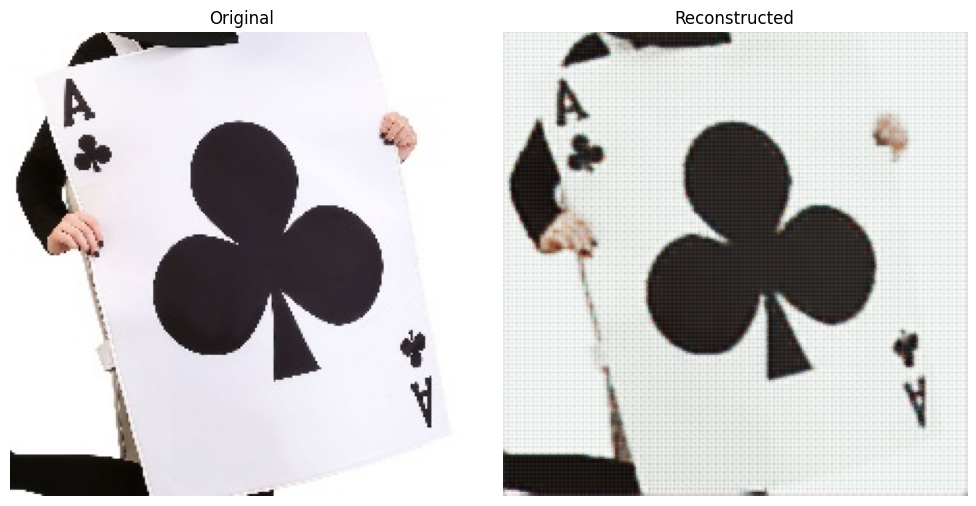

In [49]:
for image, _ in cards_aug.train_data:
    image = image.unsqueeze(0)
    encoder.showEncodedImage(image)
    break


In [11]:
# Build the model
conv_blocks = []
for conv_layer in parameters['conv_layers']:
    conv_block = ConvolutionalBlock(**conv_layer)
    conv_blocks.append(conv_block)
model_aug = CNN(conv_blocks=conv_blocks, 
                image_shape=(cards_aug.img_channels, cards_aug.img_width, cards_aug.img_height),
                n_classes=parameters['n_classes'],
                out_neurons=parameters['full_layers'][0],
                activation=parameters['activation'], 
                criterion=parameters['criterion'], 
                dropout_rate=parameters['dropout_rate'],
                init_type=parameters['init_type'],
                device=parameters['device'])
model_aug = model_aug.to(model_aug.device)

In [ ]:
# Temporarily move model to CPU for the summary
model_cpu = model_aug.to("cpu")
torchsummary.summary(model_cpu, (cards_aug.img_channels, cards_aug.img_width, cards_aug.img_height), device="cpu")
# Move the model back to MPS after summary (if MPS was available)
model_aug = model_aug.to(device)

In [13]:
# Define fit parameters.
optimizer = optim.Adam
epochs = 20
lr = 1e-4
verbose = True
epch_print = 5
tolerance = 1e-3
patience = 10

In [ ]:
# Train the model and save the results
model_aug.fit(train_dataloader=cards_aug.train_dataloader, 
              optimizer=optimizer, 
              epochs=epochs, 
              lr=lr, 
              eval_dataloader=cards_aug.valid_dataloader, 
              verbose=verbose, 
              epch_print=epch_print, 
              tolerance=tolerance, 
              patience=patience)
model_aug.save(model_path=MODELS_PATH + "cards_aug_cnn.pth", 
               metrics_path=METRICS_PATH + "cards_aug_cnn.txt")

In [ ]:
# Plot the results
file_path = FIGURES_PATH + "cards_aug_metrics.png"
model_aug.plotMetrics(file_path=file_path)